In [1]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


plt.rcParams["figure.figsize"] = (8, 6)

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


### Load a model trained with MRL

In [2]:
matry_model_name = "tomaarsen/mpnet-base-nli-matryoshka"
matry_model = SentenceTransformer(matry_model_name)
matry_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False, 'architecture': 'MPNetModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

### Basic Sentences Check with MRL

In [3]:
sentences = [
    "The stock market fell sharply today.",
    "The weather is sunny and warm."
]

emb = matry_model.encode(sentences, convert_to_numpy=True)
print("Embeddings shape:", emb.shape)   # Expect (2, 768)

Embeddings shape: (2, 768)


### Load a dataset to understand MRL
AG News as an easy themed dataset: 4 labels (World, Sports, Business, Sci/Tech)

Exercise A.1 – Load & peek at AG News

In [4]:
agnews = load_dataset("SetFit/ag_news", split="train")
print(agnews)
print(agnews[0])

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 120000
})
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2, 'label_text': 'Business'}


#### ~20 sentences: 5 per theme (World, Sports, Business, Sci/Tech).

In [5]:
label_to_name = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

examples_per_label = 5
texts = []
labels = []

counts = {0: 0, 1: 0, 2: 0, 3: 0}

for ex in agnews:
    lbl = ex["label"]
    if counts[lbl] < examples_per_label:
        texts.append(ex["text"])
        labels.append(lbl)
        counts[lbl] += 1
    
    if all(c == examples_per_label for c in counts.values()):
        break

print("Collected:", len(texts), "sentences")
for t, l in zip(texts, labels):
    print(label_to_name[l], "→", t)


Collected: 20 sentences
Business → Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Business → Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Business → Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
Business → Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.
Business → Oil prices soar to 

### Experiment 1.2 – Downstream task accuracy vs dimension

#### Exercise 1.2.1 – Build a small train/test split

In [8]:
# Let’s take 2000 train, 1000 test for a quick experiment
train_ds = agnews.shuffle(seed=42).select(range(2000))
test_ds  = agnews.shuffle(seed=123).select(range(1000))

def dataset_to_text_label(ds):
    texts = [ex["text"] for ex in ds]
    labels = [ex["label"] for ex in ds]
    return texts, np.array(labels)

train_texts, train_labels = dataset_to_text_label(train_ds)
test_texts,  test_labels  = dataset_to_text_label(test_ds)

print("Train size:", len(train_texts), "Test size:", len(test_texts))


Train size: 2000 Test size: 1000


#### Exercise 1.2.2 – Encode once with full dimension

In [9]:
train_emb_full = matry_model.encode(train_texts, convert_to_numpy=True, batch_size=32, show_progress_bar=True)
test_emb_full  = matry_model.encode(test_texts,  convert_to_numpy=True, batch_size=32, show_progress_bar=True)

print("Train emb shape:", train_emb_full.shape)
print("Test emb shape:", test_emb_full.shape)


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Train emb shape: (2000, 768)
Test emb shape: (1000, 768)


#### Exercise 1.2.3 – Train + evaluate classifier for each dimension

In [11]:
def truncate_and_normalize(embeddings: np.ndarray, d: int) -> np.ndarray:
    truncated = embeddings[:, :d]
    norms = np.linalg.norm(truncated, axis=1, keepdims=True) + 1e-12
    return truncated / norms


In [13]:
dims = [64, 128, 256, 512, train_emb_full.shape[1]]
results = []

for d in dims:
    X_train_d = truncate_and_normalize(train_emb_full, d)
    X_test_d  = truncate_and_normalize(test_emb_full, d)
    
    clf = LogisticRegression(
        max_iter=1000,
        # multi_class="multinomial",
        n_jobs=-1
    )
    clf.fit(X_train_d, train_labels)
    
    preds = clf.predict(X_test_d)
    acc = accuracy_score(test_labels, preds)
    results.append((d, acc))
    print(f"d={d:3d} → accuracy={acc:.4f}")


d= 64 → accuracy=0.8170
d=128 → accuracy=0.8340
d=256 → accuracy=0.8620
d=512 → accuracy=0.8740
d=768 → accuracy=0.8720


### Experiment 1.3 – Matryoshka vs non-Matryoshka

In [14]:
baseline_model_name = "tomaarsen/mpnet-base-nli"  # from HF Matryoshka blog
baseline_model = SentenceTransformer(baseline_model_name)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [15]:
base_train_emb_full = baseline_model.encode(train_texts, convert_to_numpy=True, batch_size=32, show_progress_bar=True)
base_test_emb_full  = baseline_model.encode(test_texts,  convert_to_numpy=True, batch_size=32, show_progress_bar=True)


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [17]:
dims = [64, 128, 256, 512, base_train_emb_full.shape[1]]

base_results = []

for d in dims:
    X_train_d = truncate_and_normalize(base_train_emb_full, d)
    X_test_d  = truncate_and_normalize(base_test_emb_full, d)
    
    clf = LogisticRegression(
        max_iter=1000,
        # multi_class="multinomial",
        n_jobs=-1
    )
    clf.fit(X_train_d, train_labels)
    
    preds = clf.predict(X_test_d)
    acc = accuracy_score(test_labels, preds)
    base_results.append((d, acc))
    print(f"[BASE] d={d:3d} → accuracy={acc:.4f}")


[BASE] d= 64 → accuracy=0.8210
[BASE] d=128 → accuracy=0.8390
[BASE] d=256 → accuracy=0.8630
[BASE] d=512 → accuracy=0.8710
[BASE] d=768 → accuracy=0.8700


### Exercise 1.3.4 – Plot both curves together

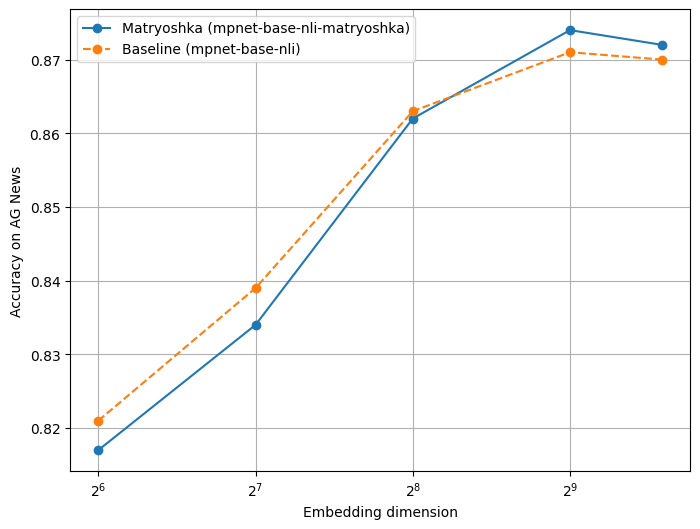

[W1120 15:28:11.525628399 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1120 15:28:21.427052552 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1120 15:28:21.854652427 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1120 15:28:22.276275257 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1120 15:28:22.700369967 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1120 15:28:23.132107839 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1120 15:28:23.559308610 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecat

In [19]:
import matplotlib.pyplot as plt

def unpack(results):
    dims = [r[0] for r in results]
    accs = [r[1] for r in results]
    return dims, accs

matry_dims, matry_accs = unpack(results)       # from 1.2
base_dims, base_accs   = unpack(base_results)  # from 1.3

plt.plot(matry_dims, matry_accs, marker="o", label="Matryoshka (mpnet-base-nli-matryoshka)")
plt.plot(base_dims, base_accs, marker="o", linestyle="--", label="Baseline (mpnet-base-nli)")
plt.xlabel("Embedding dimension")
plt.ylabel("Accuracy on AG News")
plt.xscale("log", base=2)   # optional: log scale (64,128,256,...)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from numpy.linalg import norm

def truncate_and_normalize(embeddings, d):
    """
    embeddings: (N, D_full)
    d: truncation dimension (<= D_full)
    Returns: (N, d) normalized embeddings
    """
    emb_trunc = embeddings[:, :d]
    # L2 normalize
    norms = norm(emb_trunc, axis=1, keepdims=True) + 1e-8
    emb_norm = emb_trunc / norms
    return emb_norm

def cosine_similarity_matrix(embeddings):
    """
    embeddings: (N, d), assumed L2-normalized
    Returns: (N, N) cosine similarity matrix
    """
    return np.matmul(embeddings, embeddings.T)


In [ ]:
truncate_dims = [64, 128, 256, 512, full_dim]

N = len(all_sentences)
theme_array = np.array(themes)

In [ ]:

results = []

for d in truncate_dims:
    emb_d = truncate_and_normalize(emb_full, d)
    sim_mat = cosine_similarity_matrix(emb_d)
    
    # Collect within-theme and across-theme similarities
    within_sims = []
    across_sims = []
    
    for i in range(N):
        for j in range(i + 1, N):
            same_theme = (theme_array[i] == theme_array[j])
            if same_theme:
                within_sims.append(sim_mat[i, j])
            else:
                across_sims.append(sim_mat[i, j])
    
    results.append({
        "dim": d,
        "mean_within": float(np.mean(within_sims)),
        "mean_across": float(np.mean(across_sims)),
        "std_within": float(np.std(within_sims)),
        "std_across": float(np.std(across_sims)),
    })

results


In [ ]:
dims = [r["dim"] for r in results]
within = [r["mean_within"] for r in results]
across = [r["mean_across"] for r in results]

plt.figure()
plt.plot(dims, within, marker="o", label="Within-theme similarity")
plt.plot(dims, across, marker="o", label="Across-theme similarity")
plt.xlabel("Truncation dimension (d)")
plt.ylabel("Mean cosine similarity")
plt.title("Matryoshka: Within vs Across Theme Similarities")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def plot_similarity_heatmap(embeddings, title):
    emb_norm = truncate_and_normalize(embeddings, embeddings.shape[1])
    sim_mat = cosine_similarity_matrix(emb_norm)
    
    plt.figure(figsize=(8, 7))
    sns.heatmap(sim_mat, vmin=-1, vmax=1, cmap="coolwarm", annot=False)
    plt.title(title)
    plt.xlabel("Sentence index")
    plt.ylabel("Sentence index")
    plt.show()

# For a specific d, we can just truncate emb_full then plot
d_small = 64
emb_64 = truncate_and_normalize(emb_full, d_small)
sim_64 = cosine_similarity_matrix(emb_64)

plt.figure(figsize=(8, 7))
sns.heatmap(sim_64, vmin=-1, vmax=1, cmap="coolwarm")
plt.title(f"Cosine Similarity (d={d_small})")
plt.xlabel("Sentence index")
plt.ylabel("Sentence index")
plt.show()

# And for full dim:
emb_full_norm = truncate_and_normalize(emb_full, full_dim)
sim_full = cosine_similarity_matrix(emb_full_norm)

plt.figure(figsize=(8, 7))
sns.heatmap(sim_full, vmin=-1, vmax=1, cmap="coolwarm")
plt.title(f"Cosine Similarity (d={full_dim})")
plt.xlabel("Sentence index")
plt.ylabel("Sentence index")
plt.show()
